Code below is used for retrival of 311 data from data.boston.gov from period 2016-02-01 to 2018-03-30 

In [1]:
import urllib.request
from urllib.request import quote 
import json
import pymongo 

def parseURL(url):
    return quote(url, safe='://*\'?=')

client = pymongo.MongoClient()
repo = client.repo
repo.authenticate('bemullen_crussack_dharmesh_vinwah', 'bemullen_crussack_dharmesh_vinwah')

key = "service_requests"
ID  = 'bemullen_crussack_dharmesh_vinwah'

# Retrive 311 data from data.boston.gov from period 2016-02-01 to 2018-03-30
url = parseURL('''https://data.boston.gov/api/3/action/datastore_search_sql?sql=SELECT * from "2968e2c0-d479-49ba-a884-4ef523ada3c0" WHERE "open_dt" >= '2016-02-01 00:00:00' AND "open_dt" <= '2018-03-30 00:00:00' ''')
response = urllib.request.urlopen(url).read().decode("utf-8")
r = json.loads(response)['result']['records']

#insert data in mongoDB under collection "bemullen_crussack_dharmesh_vinwah.service_requests"
repo.drop_collection(ID + '.' + key)
repo.create_collection(ID + '.' + key)
repo[ID + '.' + key].insert_many(r)
repo.logout()

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: Database.logout() is deprecated


Code below transform the 311 data, find the minimum amount of people required to accomodate all incoming calls, find average and standard diviation of minimum amount of people required to accomodate each incoming call

In [2]:
# Filename: TransformServiceRequestsTemp.py
# Author: Vincent Wahl <vinwah@bu.edu>
#
import datetime
import pymongo
from operator import itemgetter
import numpy as np


def select(R, s):
    return [t for t in R if s(t)]

def project(R, p):
    return [p(t) for t in R]

# optimization solver:  given time intervals of work loads, what is the amount of resources required to accomodate
#                       for all the jobs
# input:  intervals in a list with elements on form (datetime(start_time), datetime(end_time))
# output: (minimum number of resources on maximum load, average number of resources, standared diviation of resources, total amount of intervals)
def intervalPartitioning(data):
    # sort in increasing order of start times
    D = sorted(data, key=itemgetter(0))

    # project on form (start_time, end_time, [unavailable_resource,...], assigned_resource)
    D = project(D, lambda x: (x[0],x[1],[],-1)) 
    
    # resource list, extended if needed
    resources = [0]

    for i in range(len(D)):
        
        # find available resource
        for resource in resources:
            # assign a resource that is not in its unavailable list
            if resource not in D[i][2]:
                D[i] = (D[i][0], D[i][1], D[i][2], resource)
        
        # if no resource is available, extend resources by one and assign to interval
        if D[i][3] == -1:
            resource = len(resources)
            resources.append(resource)
            D[i] = (D[i][0], D[i][1], D[i][2], resource)

        # put P[i]'s resource into unavailable list of P[j] if j's start time overlap with i's
        for j in range(i+1, len(D)):
            if D[i][1] < D[j][0]:
                break
            D[j][2].append(D[i][3])

    # number of resources required to accomodate each resource
    resources_required = project(D, lambda x: len(x[2])+1)

    avg_resources_required   = np.mean(resources_required)
    stdv__resources_required = np.std(resources_required)

    return (len(resources), avg_resources_required, stdv__resources_required, len(D))



time_to_call = datetime.timedelta(seconds=180)                                      #Expected time of each call
length_of_period = datetime.timedelta(days=10)                                      #Legnth of each period to look at
start_date = datetime.datetime.strptime('2016-02-01 00:00:00', '%Y-%m-%d %H:%M:%S') #start of first period

client = pymongo.MongoClient()
repo = client.repo
repo.authenticate('bemullen_crussack_dharmesh_vinwah', 'bemullen_crussack_dharmesh_vinwah')

#load service requests from repo
service_requests = repo['bemullen_crussack_dharmesh_vinwah.service_requests']

# project data on form (start_time, end_time, type)
d = lambda x: (datetime.datetime.strptime(x['open_dt'], '%Y-%m-%dT%H:%M:%S'), datetime.datetime.strptime(x['open_dt'], '%Y-%m-%dT%H:%M:%S')+time_to_call, x['TYPE'])
D = project(service_requests.find(), d)

# filter data on relevant inquiries
f = lambda x: x[2] in ["Improper Storage of Trash (Barrels)", "Student Move-in Issues",\
                       "Unsafe Dangerous Conditions", "Overflowing or Un-kept Dumpster",\
                       "Squalid Living Conditions", "Illegal Posting of Signs",\
                       "Undefined Noise Disturbance", "Loud Parties/Music/People",\
                       "Bicycle Issues", "Student Overcrowding", "Illegal Rooming House",\
                       "Parking on Front/Back Yards (Illegal Parking)", "Trash on Vacant Lot",\
                       "Parking Enforcement"]
D = select(D, f)

# project data on form (start_time, end_time)
d = lambda x: (x[0], x[1])
D = project(D, d)

# variables to iterate over
period_start = start_date                   # start of period 
period_end = start_date + length_of_period  # end of period

# return true if inquiries is in the period
s = lambda x: period_start <= x[0] <= period_end or period_start <= x[1] <= period_end

data = []
# iterate over all periods
while(period_end < datetime.datetime.strptime('2018-03-30 00:00:00', '%Y-%m-%d %H:%M:%S')):
    # filter inquiries from period
    dates_in_period = select(D, s)
    # find max, avg, std, and total_number_of_inquiries for period
    (max_required, avg_required, std_required,total_number_of_inquiries) = intervalPartitioning(dates_in_period)

    data.append( (period_start,period_end,max_required,avg_required,std_required,total_number_of_inquiries) )
    period_start = period_end
    period_end = period_end + length_of_period

result = []
# put into mongoDB dictionary format
for d in data:
    result.append({'start': d[0], 'end': d[1], 'max_required': d[2], 'avg_required': d[3], 'std_required': d[4], 'total_number_of_inquiries': d[5]})

#insert into mongoDB, collection "bemullen_crussack_dharmesh_vinwah.service_request_personel_required"
repo.drop_collection('bemullen_crussack_dharmesh_vinwah.service_request_personel_required')
repo.create_collection('bemullen_crussack_dharmesh_vinwah.service_request_personel_required')
repo['bemullen_crussack_dharmesh_vinwah.service_request_personel_required'].insert_many(result)


# Selected periods we especialy want to look at
selected_periods = [datetime.datetime.strptime('2016-08-30 00:00:00', '%Y-%m-%d %H:%M:%S'),
                    datetime.datetime.strptime('2017-08-30 00:00:00', '%Y-%m-%d %H:%M:%S'),

                    datetime.datetime.strptime('2016-12-22 00:00:00', '%Y-%m-%d %H:%M:%S'),
                    datetime.datetime.strptime('2017-12-22 00:00:00', '%Y-%m-%d %H:%M:%S'),

                    datetime.datetime.strptime('2016-06-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
                    datetime.datetime.strptime('2017-06-01 00:00:00', '%Y-%m-%d %H:%M:%S'),

                    datetime.datetime.strptime('2016-10-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
                    datetime.datetime.strptime('2017-10-01 00:00:00', '%Y-%m-%d %H:%M:%S'),

                    datetime.datetime.strptime('2016-02-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
                    datetime.datetime.strptime('2017-02-01 00:00:00', '%Y-%m-%d %H:%M:%S'),
                   ]

data = []
for period_start in selected_periods:
    period_end   = period_start + datetime.timedelta(days=10)

    # filter inquiries from period
    dates_in_period = select(D, lambda x: period_start <= x[0] <= period_end or
                                          period_start <= x[1] <= period_end)
    # find max, avg, std, and total_number_of_inquiries for period
    (max_required,avg_required,std_required,total_number_of_inquiries) = intervalPartitioning(dates_in_period)
    data.append( (period_start,period_end,max_required,avg_required,std_required,total_number_of_inquiries) )

result = []
# put into mongoDB dictionary format
for d in data:
    result.append({'start': d[0], 'end': d[1], 'max_required': d[2], 'avg_required': d[3], 'std_required':d[4], 'total_number_of_inquiries':d[5]})

#insert into mongoDB, collection "bemullen_crussack_dharmesh_vinwah.service_request_personel_required_specific_periods"
repo.drop_collection('bemullen_crussack_dharmesh_vinwah.service_request_personel_required_specific_periods')
repo.create_collection('bemullen_crussack_dharmesh_vinwah.service_request_personel_required_specific_periods')
repo['bemullen_crussack_dharmesh_vinwah.service_request_personel_required_specific_periods'].insert_many(result)

repo.logout()

/Users/vincentwahl/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: Database.logout() is deprecated


Graph data

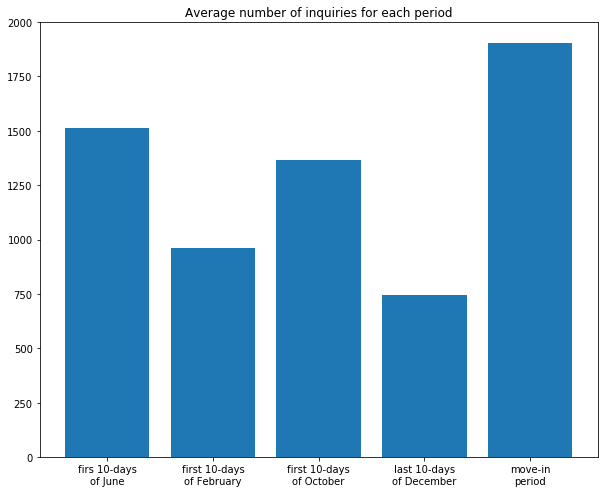

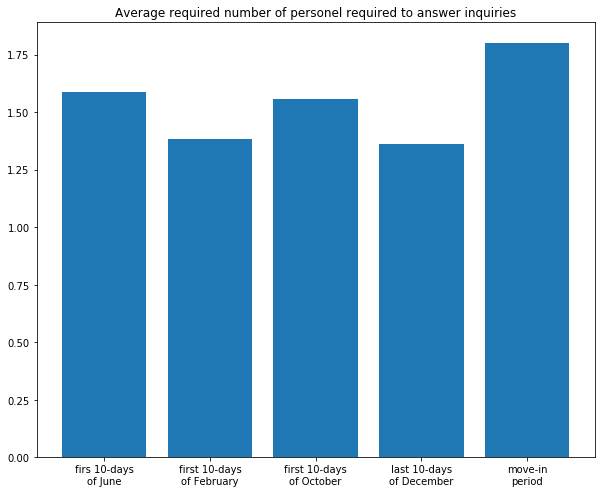

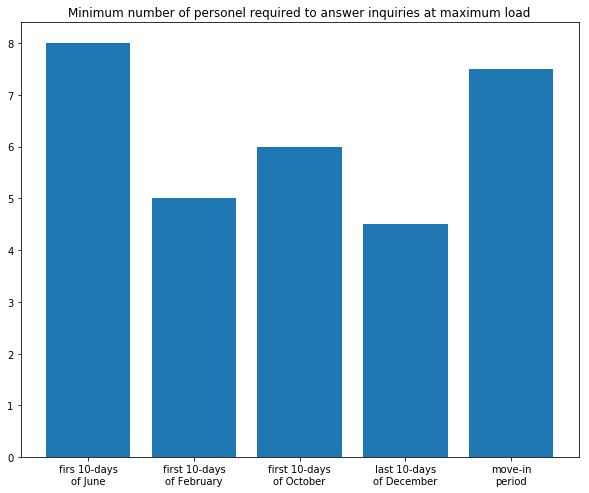

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

client = pymongo.MongoClient()
repo = client.repo
repo.authenticate('bemullen_crussack_dharmesh_vinwah', 'bemullen_crussack_dharmesh_vinwah')

#load service requests from repo
D = repo['bemullen_crussack_dharmesh_vinwah.service_request_personel_required_specific_periods']

df = pd.DataFrame(list(D.find()))

df = df[['start', 'end', 'max_required', 'avg_required', 'std_required', 'total_number_of_inquiries']]


# plot average number of inquiries for each period
x = ['move-in\nperiod', 'last 10-days\nof December', 'firs 10-days\nof June', 'first 10-days\nof October', 'first 10-days\nof February']
y = df['total_number_of_inquiries'].tolist()
y = [(y[i]+y[i+1])/2 for i in range(0, len(y), 2)]

plt.figure(figsize=(10,8))
plt.bar(x, y, align='center')
plt.title('Average number of inquiries for each period')
plt.show()


#plot average required number of personel required to answer inquiries
x = ['move-in\nperiod', 'last 10-days\nof December', 'firs 10-days\nof June', 'first 10-days\nof October', 'first 10-days\nof February']
y = df['avg_required'].tolist()
y = [(y[i]+y[i+1])/2 for i in range(0, len(y), 2)]

plt.figure(figsize=(10,8))
plt.bar(x, y, align='center')
plt.title('Average required number of personel required to answer inquiries')
plt.show()

#plot minimum number of personel required to answer inquiries at maximum load
x = ['move-in\nperiod', 'last 10-days\nof December', 'firs 10-days\nof June', 'first 10-days\nof October', 'first 10-days\nof February']
y = df['max_required'].tolist()
y = [(y[i]+y[i+1])/2 for i in range(0, len(y), 2)]

plt.figure(figsize=(10,8))
plt.bar(x, y, align='center')
plt.title('Minimum number of personel required to answer inquiries at maximum load')
plt.show()

